In [26]:
# Cell 1: Install required packages
!pip install qiskit qiskit-machine-learning qiskit-algorithms scikit-learn pandas numpy
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 6.9 MB/s eta 0:00:00


In [21]:
# Cell 1: Imports + load data + preprocessing (fit only on TRAIN)

# !pip install -q imbalanced-learn qiskit qiskit-machine-learning # Packages already installed by other cells

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

# Qiskit imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
# from scipy.optimize import COBYLA  # Removed the problematic import
# from qiskit.utils import algorithm_globals # Deprecated
from qiskit_machine_learning.algorithms.classifiers import VQC

# Set random seed using numpy as algorithm_globals is deprecated
np.random.seed(42)

# === 1. Load your 3 manually split datasets ===
# Adjust paths if needed
# These files are already loaded by cell xhl9zSBV5v6a into df_train, df_test2, df_test3
train_df = df_train
val_df   = df_test2
test_df  = df_test3

# Basic cleaning similar to your earlier code
for df in (train_df, val_df, test_df):
    # Scale Amount using only TRAIN stats later, so don't transform yet
    pass

# Scale 'Amount' on TRAIN, then apply same scaler to VAL & TEST
amount_scaler = StandardScaler()
train_df['Amount'] = amount_scaler.fit_transform(
    train_df[['Amount']]
)
val_df['Amount'] = amount_scaler.transform(val_df[['Amount']])
test_df['Amount'] = amount_scaler.transform(test_df[['Amount']])

# Drop duplicates (optional)
train_df = train_df.drop_duplicates()
val_df   = val_df.drop_duplicates()
test_df  = test_df.drop_duplicates()

# Features / labels
feature_cols = [c for c in train_df.columns if c != 'Class']

X_train_raw = train_df[feature_cols].values
y_train     = train_df['Class'].values

X_val_raw   = val_df[feature_cols].values
y_val       = val_df['Class'].values

X_test_raw  = test_df[feature_cols].values
y_test      = test_df['Class'].values

print("Train shape:", X_train_raw.shape)
print("Val shape:  ", X_val_raw.shape)
print("Test shape: ", X_test_raw.shape)

# === 2. Global feature scaler: fit ONLY on train, transform val & test ===
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
X_val_scaled   = feature_scaler.transform(X_val_raw)
X_test_scaled  = feature_scaler.transform(X_test_raw)

# === 3. SMOTE: ONLY on TRAIN (Option 1) ===
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after SMOTE on TRAIN:")
print(pd.Series(y_train_smote).value_counts())

# === 4. PCA & MinMax for Quantum (fit ONLY on TRAIN_SMOTE) ===
n_qubits = 4  # number of PCA features / qubits

pca = PCA(n_components=n_qubits, random_state=42)
X_train_pca_smote = pca.fit_transform(X_train_smote)

mm_scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_q_smote = mm_scaler.fit_transform(X_train_pca_smote)

# Load your three splits
df_train = load_csv("part1.csv")
df_test2 = load_csv("part2.csv")
df_test3 = load_csv("part3.csv")

# Prepare quantum inputs for original train, val, test (NO SMOTE)
X_train_pca_orig = pca.transform(X_train_scaled)
X_val_pca        = pca.transform(X_val_scaled)
X_test_pca       = pca.transform(X_test_scaled)

X_train_q_orig = mm_scaler.transform(X_train_pca_orig)
X_val_q        = mm_scaler.transform(X_val_pca)
X_test_q       = mm_scaler.transform(X_test_pca)

print("\nQuantum input shapes:")
print("Train_q (SMOTE):", X_train_q_smote.shape)
print("Train_q (orig): ", X_train_q_orig.shape)
print("Val_q:          ", X_val_q.shape)
print("Test_q:         ", X_test_q.shape)


Train shape: (94585, 30)
Val shape:   (94605, 30)
Test shape:  (94536, 30)

Class distribution after SMOTE on TRAIN:
0    94368
1    94368
Name: count, dtype: int64
Loaded part1.csv: shape=(94936, 31)
Loaded part2.csv: shape=(94936, 31)
Loaded part3.csv: shape=(94935, 31)

Quantum input shapes:
Train_q (SMOTE): (188736, 4)
Train_q (orig):  (94585, 4)
Val_q:           (94605, 4)
Test_q:          (94536, 4)


In [11]:
# Cell 2: Imports, dataset loader, and utilities

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

BASE_PATH = "/content/drive/MyDrive"
DATA_DIR = BASE_PATH

def load_csv(file_name, base_path=DATA_DIR):
    path = os.path.join(base_path, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {file_name}: shape={df.shape}")
    return df

# Load your three splits
df_train = load_csv("part1.csv")
df_test2 = load_csv("part2.csv")
df_test3 = load_csv("part3.csv")

# Utility: evaluation
def evaluate_scores(y_true, y_score, name="Model", fpr_target=0.01, top_k=1000):
    results = {}
    results["name"] = name
    results["AUROC"] = roc_auc_score(y_true, y_score)
    results["AUPRC"] = average_precision_score(y_true, y_score)

    fpr, tpr, thr = roc_curve(y_true, y_score)
    idx = np.argmin(np.abs(fpr - fpr_target))
    thr_fpr = thr[idx]
    y_pred_fpr = (y_score >= thr_fpr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_fpr).ravel()
    results["Threshold@FPR"] = thr_fpr
    results["Recall@FPR"] = tp / (tp + fn)
    results["Precision@FPR"] = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    k = min(top_k, len(y_score))
    idx = np.argsort(-y_score)[:k]
    precision_top_k = y_true[idx].sum() / k
    results[f"Precision@Top_{k}"] = precision_top_k

    print(f"\n=== {name} ===")
    for k, v in results.items():
        print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")
    return results

Mounted at /content/drive
Loaded part1.csv: shape=(94936, 31)
Loaded part2.csv: shape=(94936, 31)
Loaded part3.csv: shape=(94935, 31)


In [12]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
df_train.shape

(94936, 31)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94936 entries, 0 to 94935
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    94936 non-null  float64
 1   V1      94936 non-null  float64
 2   V2      94936 non-null  float64
 3   V3      94936 non-null  float64
 4   V4      94936 non-null  float64
 5   V5      94936 non-null  float64
 6   V6      94936 non-null  float64
 7   V7      94936 non-null  float64
 8   V8      94936 non-null  float64
 9   V9      94936 non-null  float64
 10  V10     94936 non-null  float64
 11  V11     94936 non-null  float64
 12  V12     94936 non-null  float64
 13  V13     94936 non-null  float64
 14  V14     94936 non-null  float64
 15  V15     94936 non-null  float64
 16  V16     94936 non-null  float64
 17  V17     94936 non-null  float64
 18  V18     94936 non-null  float64
 19  V19     94936 non-null  float64
 20  V20     94936 non-null  float64
 21  V21     94936 non-null  float64
 22

In [17]:
df_train['Class'].value_counts()

,count
Class,
0,94719
1,217


In [18]:
# Cell 2: Evaluation helper functions (used by all models)

def evaluate_sklearn_model(model, X, y, name, plot_curves=True):
    """Evaluate a sklearn model with predict_proba."""
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
    else:
        # fallback
        y_proba = y_pred.astype(float)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y, y_proba)

    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp + 1e-8)

    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy:     {acc:.4f}")
    print(f"Precision:    {prec:.4f}")
    print(f"Recall:       {rec:.4f}")
    print(f"Specificity:  {specificity:.4f}")
    print(f"F1-score:     {f1:.4f}")
    print(f"ROC-AUC:      {roc_auc:.4f}")

    if plot_curves:
        fpr, tpr, _ = roc_curve(y, y_proba)
        prec_curve, rec_curve, _ = precision_recall_curve(y, y_proba)

        plt.figure(figsize=(12, 5))

        # ROC
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC - {name}')
        plt.legend()

        # Precision–Recall
        plt.subplot(1, 2, 2)
        plt.plot(rec_curve, prec_curve)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision–Recall - {name}')

        plt.tight_layout()
        plt.show()

    return y_pred, y_proba


def evaluate_from_probas(y_true, y_pred, y_proba, name, plot_curves=True):
    """Evaluate when we already have y_pred and y_proba (e.g. VQC, ensemble)."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp + 1e-8)

    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy:     {acc:.4f}")
    print(f"Precision:    {prec:.4f}")
    print(f"Recall:       {rec:.4f}")
    print(f"Specificity:  {specificity:.4f}")
    print(f"F1-score:     {f1:.4f}")
    print(f"ROC-AUC:      {roc_auc:.4f}")

    if plot_curves:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_proba)

        plt.figure(figsize=(12, 5))

        # ROC
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC - {name}')
        plt.legend()

        # Precision–Recall
        plt.subplot(1, 2, 2)
        plt.plot(rec_curve, prec_curve)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision–Recall - {name}')

        plt.tight_layout()
        plt.show()



=== Logistic Regression (TRAIN / part1) ===
Confusion Matrix:
[[92487  1881]
 [    9   208]]
Accuracy:     0.9800
Precision:    0.0996
Recall:       0.9585
Specificity:  0.9801
F1-score:     0.1804
ROC-AUC:      0.9929


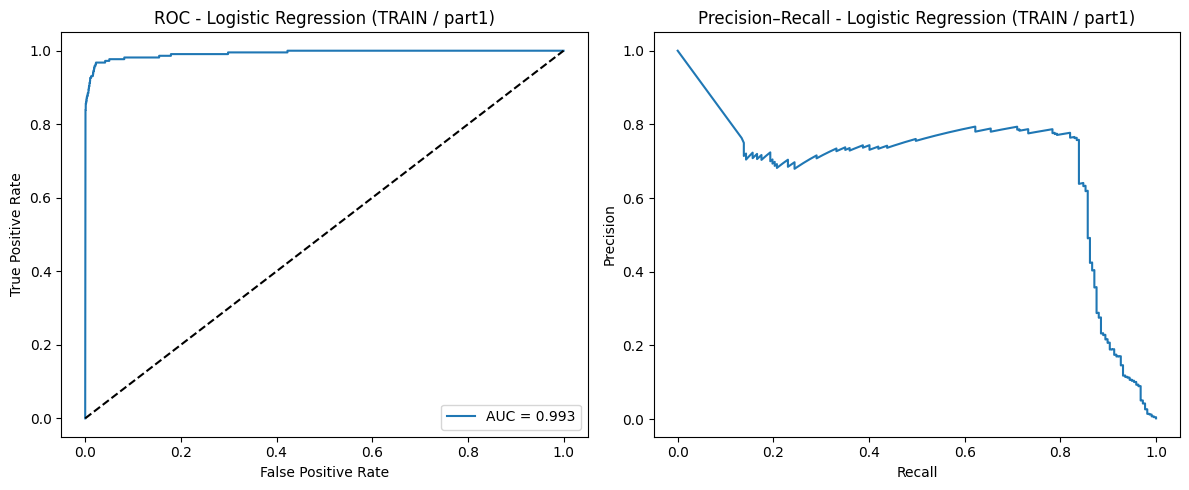


=== Logistic Regression (VALIDATION / part2) ===
Confusion Matrix:
[[89577  4893]
 [   29   106]]
Accuracy:     0.9480
Precision:    0.0212
Recall:       0.7852
Specificity:  0.9482
F1-score:     0.0413
ROC-AUC:      0.8586


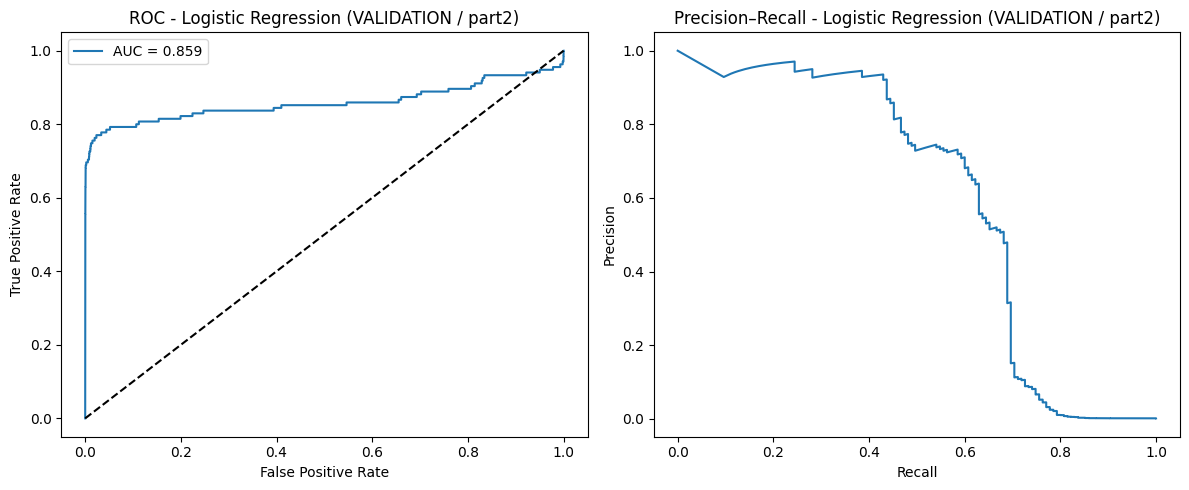


=== Logistic Regression (TEST / part3) ===
Confusion Matrix:
[[83856 10559]
 [   16   105]]
Accuracy:     0.8881
Precision:    0.0098
Recall:       0.8678
Specificity:  0.8882
F1-score:     0.0195
ROC-AUC:      0.9412


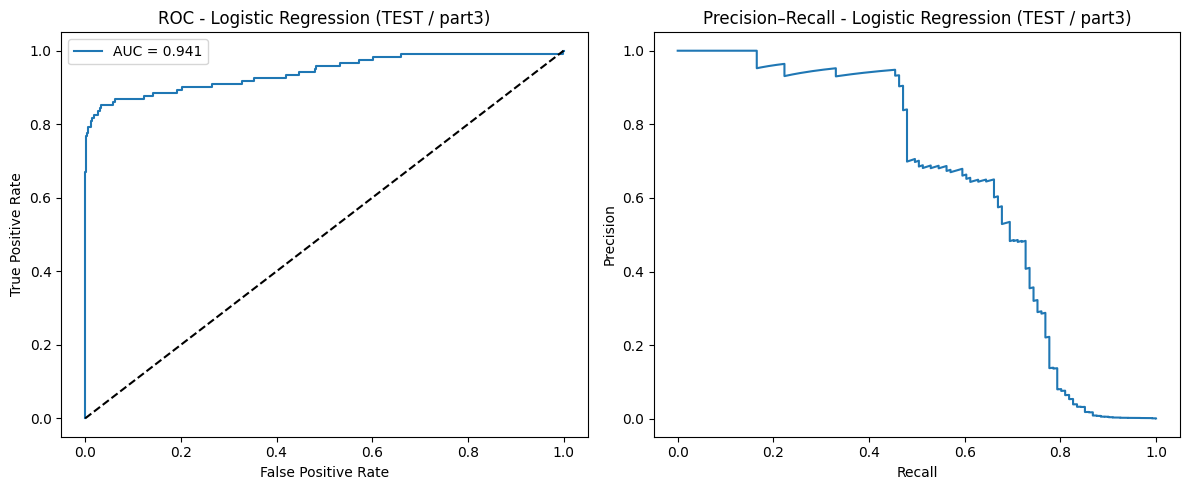


=== Random Forest (TRAIN / part1) ===
Confusion Matrix:
[[94368     0]
 [    0   217]]
Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
Specificity:  1.0000
F1-score:     1.0000
ROC-AUC:      1.0000


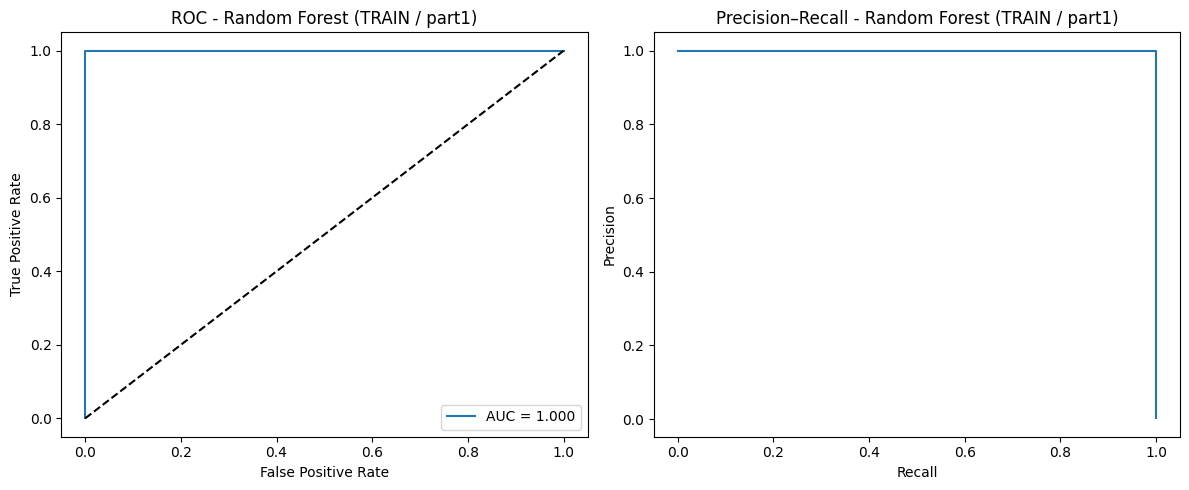


=== Random Forest (VALIDATION / part2) ===
Confusion Matrix:
[[94455    15]
 [   35   100]]
Accuracy:     0.9995
Precision:    0.8696
Recall:       0.7407
Specificity:  0.9998
F1-score:     0.8000
ROC-AUC:      0.9593


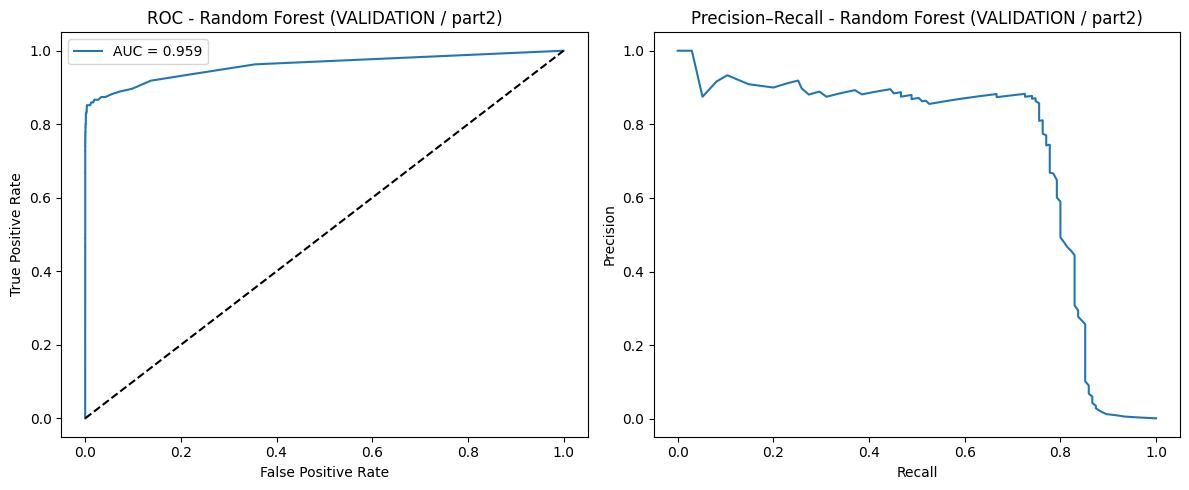


=== Random Forest (TEST / part3) ===
Confusion Matrix:
[[94409     6]
 [   34    87]]
Accuracy:     0.9996
Precision:    0.9355
Recall:       0.7190
Specificity:  0.9999
F1-score:     0.8131
ROC-AUC:      0.9581


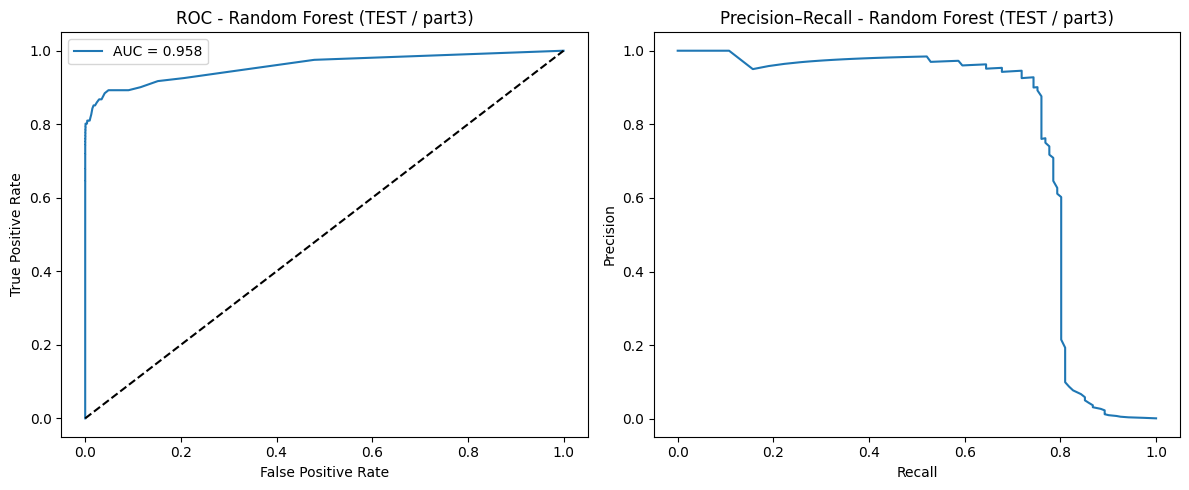

In [34]:
# Cell 3: Train Logistic Regression & Random Forest on TRAIN (SMOTE),
#         evaluate on TRAIN / VALIDATION / TEST, keep their probabilities

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# 1. Train classical models
# ----------------------------
log_reg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    class_weight=None
)
log_reg.fit(X_train_smote, y_train_smote)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_smote, y_train_smote)

# ----------------------------
# 2. Evaluate & store proba
# ----------------------------

# Logistic Regression
lr_pred_train, lr_proba_train = evaluate_sklearn_model(
    log_reg, X_train_scaled, y_train,
    "Logistic Regression (TRAIN / part1)"
)
lr_pred_val, lr_proba_val = evaluate_sklearn_model(
    log_reg, X_val_scaled, y_val,
    "Logistic Regression (VALIDATION / part2)"
)
lr_pred_test, lr_proba_test = evaluate_sklearn_model(
    log_reg, X_test_scaled, y_test,
    "Logistic Regression (TEST / part3)"
)

# Random Forest
rf_pred_train, rf_proba_train = evaluate_sklearn_model(
    rf_model, X_train_scaled, y_train,
    "Random Forest (TRAIN / part1)"
)
rf_pred_val, rf_proba_val = evaluate_sklearn_model(
    rf_model, X_val_scaled, y_val,
    "Random Forest (VALIDATION / part2)"
)
rf_pred_test, rf_proba_test = evaluate_sklearn_model(
    rf_model, X_test_scaled, y_test,
    "Random Forest (TEST / part3)"
)


In [35]:
# Cell 4: Build VQC training subset from RF "confusing region"
#         and create PCA + angle-encoded features for TRAIN/VAL/TEST

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------
# 1. Use RF proba on TRAIN
# ----------------------------------
p_RF_train = rf_proba_train  # already computed above

low_thr  = 0.2  # below this → clear normal
high_thr = 0.8  # above this → clear fraud

is_confusing = (p_RF_train >= low_thr) & (p_RF_train <= high_thr)
is_fraud     = (y_train == 1)

# VQC should train on:
#  - all frauds
#  - confusing normals
vqc_train_mask = is_confusing | is_fraud

X_train_vqc_base = X_train_scaled[vqc_train_mask]
y_train_vqc      = y_train[vqc_train_mask]
p_RF_train_vqc   = p_RF_train[vqc_train_mask]

print("VQC subset (before cap):", X_train_vqc_base.shape)

# Optionally cap to avoid huge training load
max_vqc_samples = 1000
if X_train_vqc_base.shape[0] > max_vqc_samples:
    X_train_vqc_base = X_train_vqc_base[:max_vqc_samples]
    y_train_vqc      = y_train_vqc[:max_vqc_samples]
    p_RF_train_vqc   = p_RF_train_vqc[:max_vqc_samples]

print("VQC subset (after cap):", X_train_vqc_base.shape)

# ----------------------------------
# 2. PCA on full TRAIN (for structure)
# ----------------------------------
n_qubits = 4  # number of qubits / features for VQC

pca = PCA(n_components=n_qubits, random_state=42)
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_val_pca        = pca.transform(X_val_scaled)
X_test_pca       = pca.transform(X_test_scaled)

# PCA features for VQC subset
X_train_vqc_pca = pca.transform(X_train_vqc_base)

# ----------------------------------
# 3. Build classical features for VQC
#    Design: [PCA1, PCA2, p_RF, 0]  (4D)
# ----------------------------------
X_train_vqc_classical = np.zeros((X_train_vqc_pca.shape[0], n_qubits))
X_train_vqc_classical[:, 0:2] = X_train_vqc_pca[:, 0:2]
X_train_vqc_classical[:, 2]   = p_RF_train_vqc
# last dimension stays 0 for now

# For VAL and TEST: use all samples
p_RF_val  = rf_proba_val
p_RF_test = rf_proba_test

X_val_vqc_classical = np.zeros((X_val_pca.shape[0], n_qubits))
X_val_vqc_classical[:, 0:2] = X_val_pca[:, 0:2]
X_val_vqc_classical[:, 2]   = p_RF_val

X_test_vqc_classical = np.zeros((X_test_pca.shape[0], n_qubits))
X_test_vqc_classical[:, 0:2] = X_test_pca[:, 0:2]
X_test_vqc_classical[:, 2]   = p_RF_test

# Also create classical matrix for FULL TRAIN (for evaluation later)
X_train_full_vqc_classical = np.zeros((X_train_pca_full.shape[0], n_qubits))
X_train_full_vqc_classical[:, 0:2] = X_train_pca_full[:, 0:2]
X_train_full_vqc_classical[:, 2]   = p_RF_train

# ----------------------------------
# 4. Angle encoding: map to [0, π]
# ----------------------------------
angle_scaler = MinMaxScaler(feature_range=(0, np.pi))

X_train_vqc_angles = angle_scaler.fit_transform(X_train_vqc_classical)
X_val_vqc_angles   = angle_scaler.transform(X_val_vqc_classical)
X_test_vqc_angles  = angle_scaler.transform(X_test_vqc_classical)
X_train_full_vqc_angles = angle_scaler.transform(X_train_full_vqc_classical)

print("Angle-encoded shapes:")
print("Train subset:", X_train_vqc_angles.shape)
print("Train full:  ", X_train_full_vqc_angles.shape)
print("Val:         ", X_val_vqc_angles.shape)
print("Test:        ", X_test_vqc_angles.shape)


VQC subset (before cap): (228, 30)
VQC subset (after cap): (228, 30)
Angle-encoded shapes:
Train subset: (228, 4)
Train full:   (94585, 4)
Val:          (94605, 4)
Test:         (94536, 4)


/tmp/ipython-input-1726827891.py:7: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler   = Sampler()


Training VQC on subset: (228, 4)

=== VQC alone (TRAIN / part1) ===
Confusion Matrix:
[[88766  5602]
 [   34   183]]
Accuracy:     0.9404
Precision:    0.0316
Recall:       0.8433
Specificity:  0.9406
F1-score:     0.0610
ROC-AUC:      0.9433


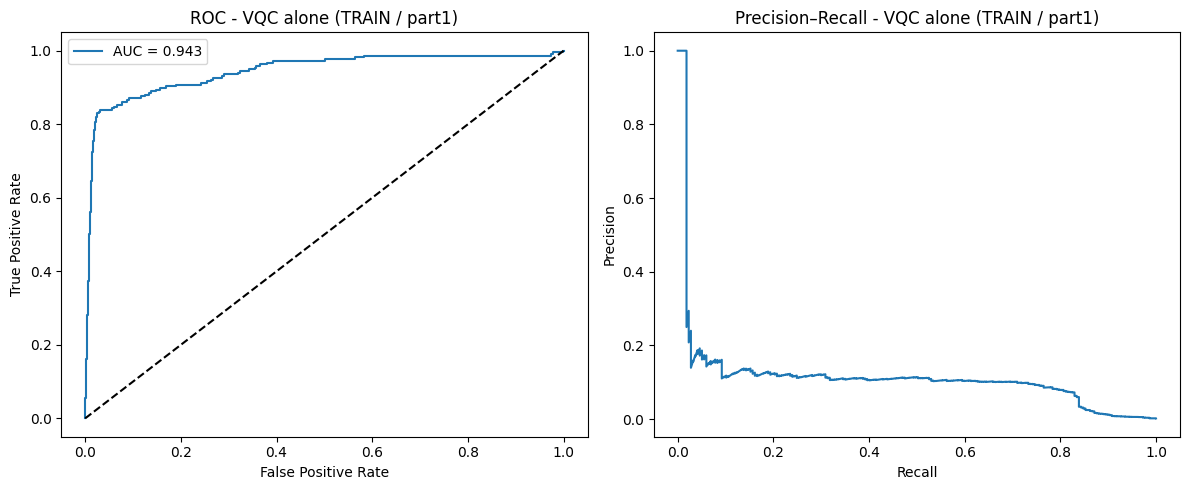


=== VQC alone (VALIDATION / part2) ===
Confusion Matrix:
[[86392  8078]
 [   45    90]]
Accuracy:     0.9141
Precision:    0.0110
Recall:       0.6667
Specificity:  0.9145
F1-score:     0.0217
ROC-AUC:      0.8124


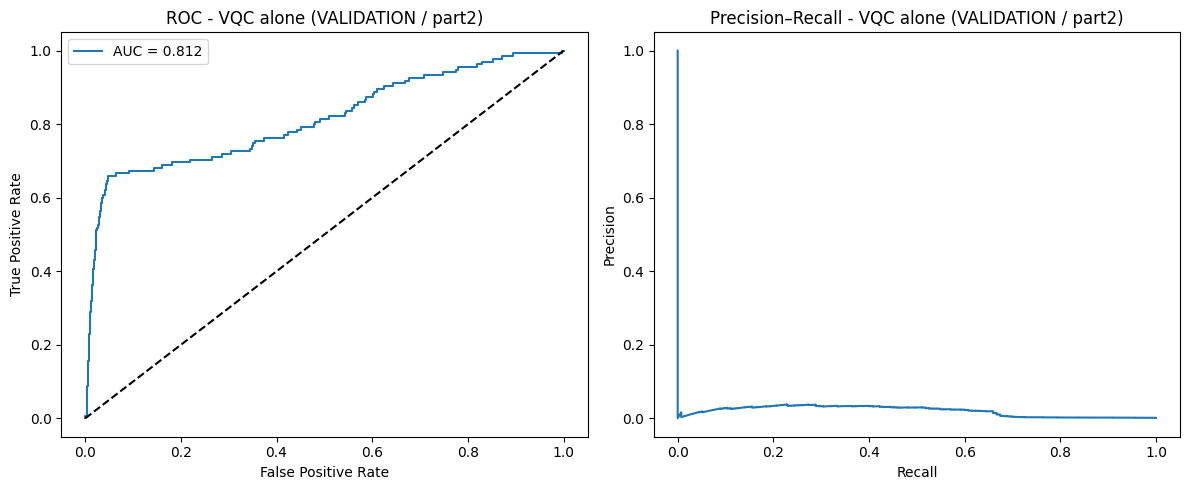


=== VQC alone (TEST / part3) ===
Confusion Matrix:
[[85296  9119]
 [   46    75]]
Accuracy:     0.9031
Precision:    0.0082
Recall:       0.6198
Specificity:  0.9034
F1-score:     0.0161
ROC-AUC:      0.7720


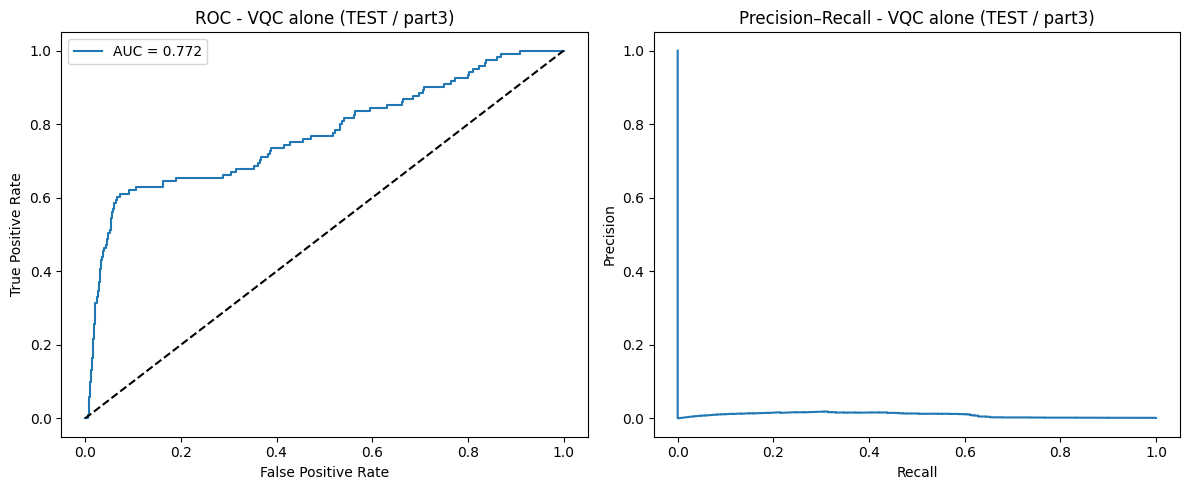

In [37]:
# Cell 5: Define VQC, train on focused subset, evaluate VQC alone on TRAIN/VAL/TEST

from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA

# 1. Quantum setup: sampler, optimizer, feature map, ansatz
sampler   = Sampler()
optimizer = COBYLA(maxiter=40)  # keep iterations moderate

feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz      = RealAmplitudes(num_qubits=n_qubits, reps=1)

vqc = VQC(
    num_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    # sampler=sampler, # Removed as VQC no longer takes sampler directly
    loss="cross_entropy"
)

print("Training VQC on subset:", X_train_vqc_angles.shape)
vqc.fit(X_train_vqc_angles, y_train_vqc)

# 2. VQC probabilities on FULL TRAIN / VAL / TEST
vqc_proba_train = vqc.predict_proba(X_train_full_vqc_angles)[:, 1]
vqc_proba_val   = vqc.predict_proba(X_val_vqc_angles)[:, 1]
vqc_proba_test  = vqc.predict_proba(X_test_vqc_angles)[:, 1]

# Turn into labels using 0.5 for now
vqc_pred_train = (vqc_proba_train >= 0.5).astype(int)
vqc_pred_val   = (vqc_proba_val   >= 0.5).astype(int)
vqc_pred_test  = (vqc_proba_test  >= 0.5).astype(int)

# 3. Evaluate VQC as a standalone classifier
evaluate_from_probas(
    y_train, vqc_pred_train, vqc_proba_train,
    "VQC alone (TRAIN / part1)"
)
evaluate_from_probas(
    y_val, vqc_pred_val, vqc_proba_val,
    "VQC alone (VALIDATION / part2)"
)
evaluate_from_probas(
    y_test, vqc_pred_test, vqc_proba_test,
    "VQC alone (TEST / part3)"
)



=== Hybrid RF+VQC (TRAIN / part1) ===
Confusion Matrix:
[[94368     0]
 [    0   217]]
Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
Specificity:  1.0000
F1-score:     1.0000
ROC-AUC:      1.0000


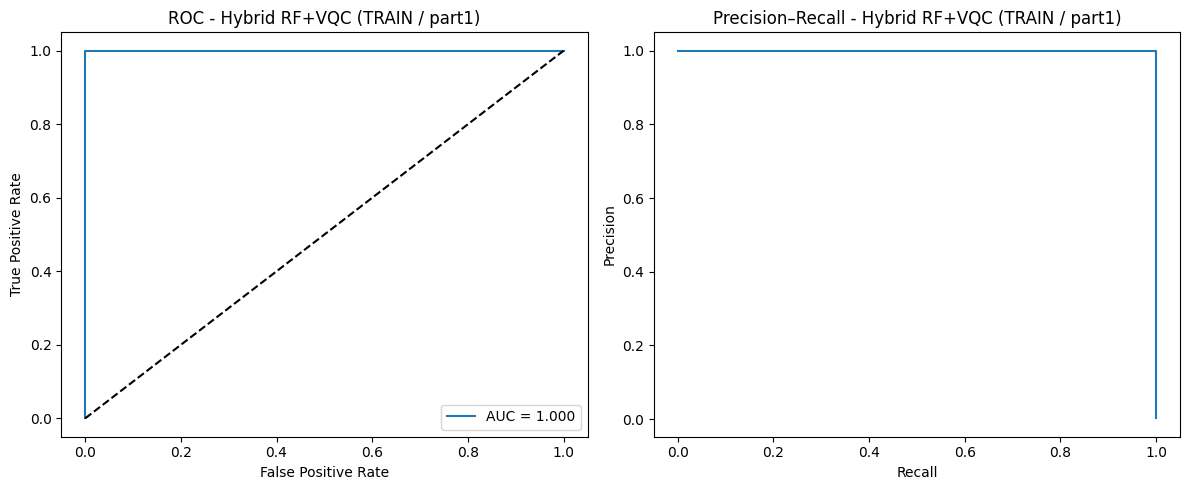


=== Hybrid RF+VQC (VALIDATION / part2) ===
Confusion Matrix:
[[94457    13]
 [   35   100]]
Accuracy:     0.9995
Precision:    0.8850
Recall:       0.7407
Specificity:  0.9999
F1-score:     0.8065
ROC-AUC:      0.9593


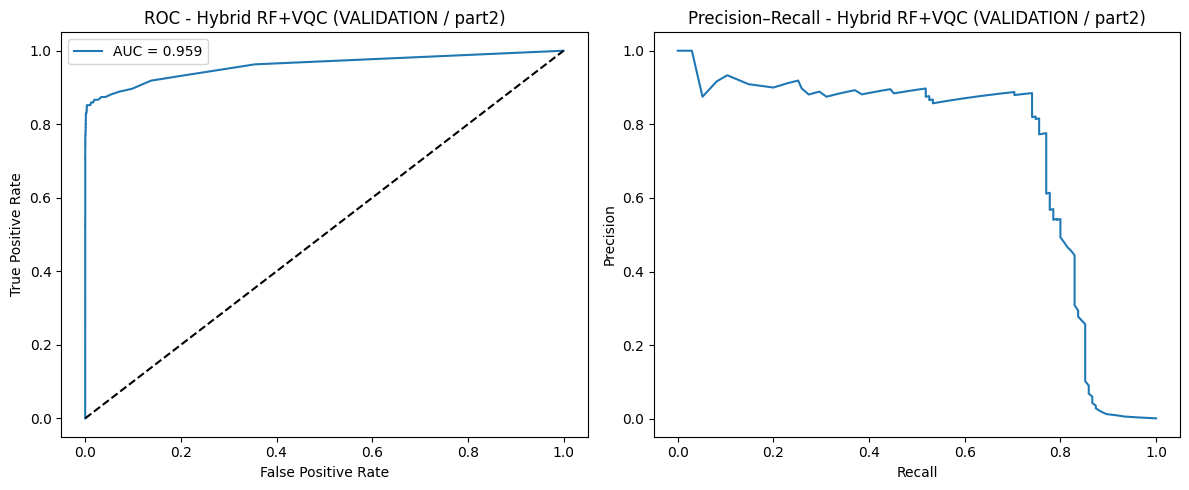


=== Hybrid RF+VQC (TEST / part3) ===
Confusion Matrix:
[[94410     5]
 [   34    87]]
Accuracy:     0.9996
Precision:    0.9457
Recall:       0.7190
Specificity:  0.9999
F1-score:     0.8169
ROC-AUC:      0.9581


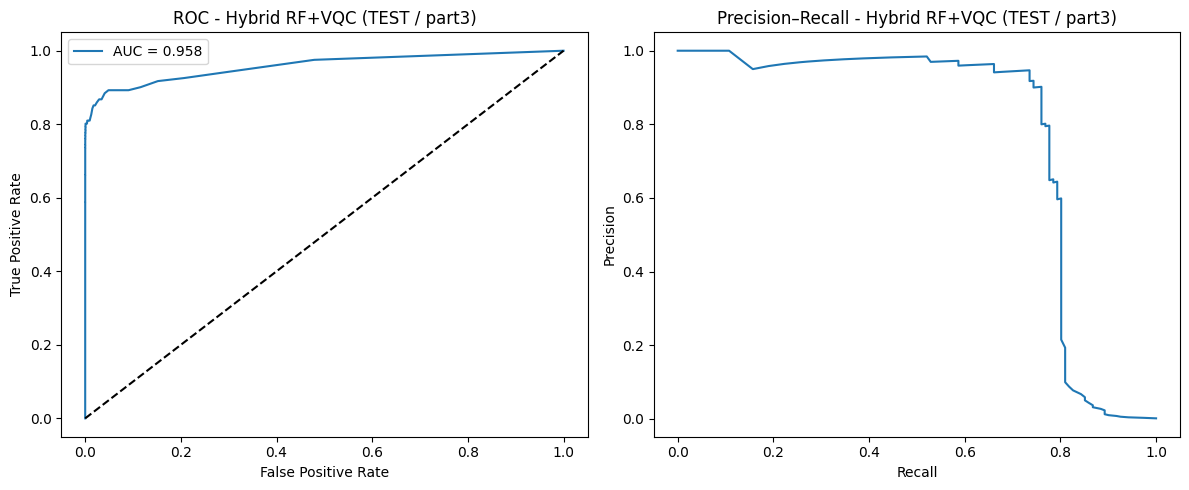


✅ Classical (LR, RF), Quantum (VQC), and Hybrid (RF+VQC) all evaluated on TRAIN / VAL / TEST.


In [38]:
# Cell 6: Hybrid RF + VQC (VQC only on confusing cases), evaluate on TRAIN/VAL/TEST

low_thr  = 0.2
high_thr = 0.8
alpha    = 0.7   # weight for RF, 0.3 for VQC

# ----------------------
# 1. TRAIN hybrid
# ----------------------
base_proba_train = rf_proba_train.copy()
use_vqc_train = (base_proba_train >= low_thr) & (base_proba_train <= high_thr)

hybrid_proba_train = base_proba_train.copy()
hybrid_proba_train[use_vqc_train] = (
    alpha * base_proba_train[use_vqc_train]
    + (1 - alpha) * vqc_proba_train[use_vqc_train]
)
hybrid_pred_train = (hybrid_proba_train >= 0.5).astype(int)

evaluate_from_probas(
    y_train, hybrid_pred_train, hybrid_proba_train,
    "Hybrid RF+VQC (TRAIN / part1)"
)

# ----------------------
# 2. VALIDATION hybrid
# ----------------------
base_proba_val = rf_proba_val.copy()
use_vqc_val = (base_proba_val >= low_thr) & (base_proba_val <= high_thr)

hybrid_proba_val = base_proba_val.copy()
hybrid_proba_val[use_vqc_val] = (
    alpha * base_proba_val[use_vqc_val]
    + (1 - alpha) * vqc_proba_val[use_vqc_val]
)
hybrid_pred_val = (hybrid_proba_val >= 0.5).astype(int)

evaluate_from_probas(
    y_val, hybrid_pred_val, hybrid_proba_val,
    "Hybrid RF+VQC (VALIDATION / part2)"
)

# ----------------------
# 3. TEST hybrid
# ----------------------
base_proba_test = rf_proba_test.copy()
use_vqc_test = (base_proba_test >= low_thr) & (base_proba_test <= high_thr)

hybrid_proba_test = base_proba_test.copy()
hybrid_proba_test[use_vqc_test] = (
    alpha * base_proba_test[use_vqc_test]
    + (1 - alpha) * vqc_proba_test[use_vqc_test]
)
hybrid_pred_test = (hybrid_proba_test >= 0.5).astype(int)

evaluate_from_probas(
    y_test, hybrid_pred_test, hybrid_proba_test,
    "Hybrid RF+VQC (TEST / part3)"
)

print("\n✅ Classical (LR, RF), Quantum (VQC), and Hybrid (RF+VQC) all evaluated on TRAIN / VAL / TEST.")
